<a href="https://colab.research.google.com/github/greyhound101/IEEE-CIS-Fraud/blob/master/simple_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading libraries

In [1]:
import pandas as pd
from tensorflow.keras.layers import *
import tensorflow as tf
import random, os, sys
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
from google.colab import drive
import os
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from keras.layers import *
from keras.optimizers import *
from keras.models import *
from keras import backend as K
from tensorflow.keras.models import *
import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
import gc

loading drive

In [2]:

drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Mounted at /content/gdrive


Loading data from kaggle

In [3]:

os.environ['KAGGLE_USERNAME'] = "tapaskd123" # username from the json file
os.environ['KAGGLE_KEY'] = "aba8dc1f085221111d925003fe5a88ed" # key from the json file
!kaggle competitions download -c ieee-fraud-detection

train_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


Loading dataframes

In [4]:

trn=pd.read_csv('/content/gdrive/My Drive/fraud/train.csv')
tst=pd.read_csv('/content/gdrive/My Drive/fraud/test.csv')
ls=list(trn.filter(regex='V'))
trn=trn.drop(ls,1)
tst=tst.drop(ls,1)

In [5]:
trn=trn.drop(['Unnamed: 0'],1)
tst=tst.drop(['Unnamed: 0'],1)

Getting id features

In [6]:

dum=[str(i) for i in range(444)]
isna=list(trn.filter(regex='isna'))



tot=list(set(dum+isna+['day','month','week']))
num=[ i for i in list(trn) if i not in tot]

num.remove('id')
num.remove('isFraud')
for col in tqdm(num):
  cols=[col+'_mean',col+'_std']
  trn[col+'_mean']=trn.groupby(['id'])[col].transform('mean')
  trn[col+'_std']=trn.groupby(['id'])[col].transform('std')
  
  tst[col+'_mean']=tst.groupby(['id'])[col].transform('mean')
  tst[col+'_std']=tst.groupby(['id'])[col].transform('std')
  for c in cols:
    if trn[c].skew()>1:
      trn[c]=np.log10(trn[c]+1-min(0,min(trn[c])))
      tst[c]=np.log10(tst[c]+1-min(0,min(trn[c])))
    mn=trn[c].mean()
    std=trn[c].std()
    trn[c]=(trn[c]-mn)/std
    mn=tst[c].mean()
    std=tst[c].std()
    tst[c]=(tst[c]-mn)/std 
trn=trn.drop(['id'],1)
tst=tst.drop(['id'],1)

num=[ i for i in list(trn) if i not in tot]

  6%|▌         | 2/33 [00:16<03:53,  7.55s/it]/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████| 33/33 [04:38<00:00,  8.44s/it]


Reduce memory useage

In [7]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
trn=reduce_mem_usage(trn)
tst=reduce_mem_usage(tst)

Memory usage of dataframe is 2532.07 MB
Memory usage after optimization is: 636.40 MB
Decreased by 74.9%
Memory usage of dataframe is 2168.68 MB
Memory usage after optimization is: 539.75 MB
Decreased by 75.1%


In [8]:
trn=trn.replace([np.inf,-np.inf],np.nan)
tst=tst.replace([np.inf,-np.inf],np.nan)
a=trn.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(trn[col].mean())
  tst[col]=tst[col].fillna(tst[col].mean())
a=trn.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(0)
  tst[col]=tst[col].fillna(0)
a=tst.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(trn[col].mean())
  tst[col]=tst[col].fillna(tst[col].mean())
a=tst.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(0)
  tst[col]=tst[col].fillna(0)

Making the callbacks and loading model

In [14]:
dk={}
class RocCallback(Callback):
    def __init__(self,validation_data):
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        self.ep=0

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        self.ep+=1
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('roc-auc_val: %s' % str(round(roc_val,4)))

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return
def load_model():
  K.clear_session()



  inp=Input((561,))
  x=Dense(512,activation=custom_gelu)(inp)
  x=BatchNormalization()(x)
  x=Dropout(0.3)(x)
  x=Dense(256,activation=custom_gelu)(x)
  x=Dropout(0.2)(x)
  x=Dense(1,activation='sigmoid')(x)
  mod=Model(inputs=[inp],outputs=x)
  return mod

def custom_gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

In [15]:
ln=len(trn)
train=trn.loc[:int(0.8*ln)]
test=trn.loc[int(0.8*ln):]
mod=load_model()
roc = RocCallback(
                  validation_data=(test.drop(['isFraud'],1), test['isFraud']))
mod.compile(optimizer=Nadam(),loss='binary_crossentropy')
es=EarlyStopping(monitor='val_loss',min_delta=0.0001,mode='min',restore_best_weights=True,patience=50)
mod.fit(train.drop(['isFraud'],1),train['isFraud'],validation_data=(test.drop(['isFraud'],1),test['isFraud']),batch_size=2048,epochs=8,callbacks=[es,roc])
gc.collect()


Epoch 1/8
231/231 [==============================] - 9s 40ms/step - loss: 0.1715 - val_loss: 0.1077
Epoch 2/8
231/231 [==============================] - 8s 33ms/step - loss: 0.1077 - val_loss: 0.1022
Epoch 3/8
231/231 [==============================] - 8s 33ms/step - loss: 0.0975 - val_loss: 0.1004
Epoch 4/8
231/231 [==============================] - 8s 33ms/step - loss: 0.0898 - val_loss: 0.0987
Epoch 5/8
231/231 [==============================] - 8s 33ms/step - loss: 0.0832 - val_loss: 0.0994
Epoch 6/8
231/231 [==============================] - 8s 34ms/step - loss: 0.0780 - val_loss: 0.0967
Epoch 7/8
231/231 [==============================] - 8s 33ms/step - loss: 0.0737 - val_loss: 0.0989
Epoch 8/8
231/231 [==============================] - 8s 33ms/step - loss: 0.0705 - val_loss: 0.0990


23923

In [16]:
mod.fit(test.drop(['isFraud'],1),test['isFraud'],batch_size=2048,epochs=2)
pre=mod.predict(tst)

Epoch 1/2
58/58 [==============================] - 1s 10ms/step - loss: 0.0927
Epoch 2/2
58/58 [==============================] - 1s 9ms/step - loss: 0.0810


In [17]:
sub=pd.read_csv('sample_submission.csv.zip')
sub['isFraud']=pre
sub=sub.set_index('TransactionID')
sub.head()

,isFraud
TransactionID,
3663549,0.000415
3663550,0.000115
3663551,0.000048
3663552,0.000373
3663553,0.000060


In [18]:
sub.to_csv('sub.csv')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


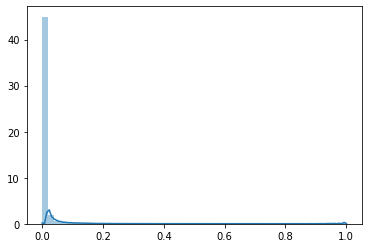

In [19]:
import seaborn as sns
sns.distplot(pre)